In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "meta-llama/Llama-3.1-8B-Instruct"  # or meta-llama/Meta-Llama-3-8B-Instruct


tok = AutoTokenizer.from_pretrained(model_id, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",                    # puts layers on GPU 0
    torch_dtype="bfloat16"                # FP16 is fine too
)
model.eval()



Loading checkpoint shards: 100%|██████████| 4/4 [00:19<00:00,  4.80s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [1]:
import json
asdf = json.load(open("steering_graph_results_12_18.json","r"))

In [2]:
bcde = json.load(open("steering_graph_results.json","r"))

In [4]:
import re
import numpy as np
def get_layer_results(asdf):
    match_digit = lambda x: re.findall(r'\d+',x)
    expected = '1'
    layerwise = {}
    failurewise = {}
    for key in asdf['pos']:
        for layer in asdf['pos'][key]:
            if layer not in layerwise:
                layerwise[layer] = {}
                failurewise[layer] = {}
            for mult in asdf['pos'][key][layer]:
                if mult not in layerwise[layer]:
                    layerwise[layer][mult] = []
                    failurewise[layer][mult] = []
                if asdf['pos'][key][layer][mult] == {}:
                    continue
                res = asdf['pos'][key][layer][mult]['neg']
                expect = asdf['pos'][key][layer][mult]['none']
                res_num = match_digit(res)
                try:
                    ex_num = match_digit(expect)[0]
                except IndexError:
                    continue
                if len(res_num) == 0:
                    res_num = ['fail']
                layerwise[layer][mult].append((res_num[0] != ex_num and res_num[0] != 'fail'))
                failurewise[layer][mult].append(res_num[0] == '2')
    layer_results = {}
    fail_results = {}
    for layer in layerwise:
        layer_results[layer]=layer_results.get(layer, {})
        fail_results[layer]=fail_results.get(layer, {})

        for mult in layerwise[layer]:
            layer_results[layer][mult]=layer_results[layer].get(mult, {})
            layer_results[layer][mult] = np.sum(layerwise[layer][mult]) / len(layerwise[layer][mult])
            fail_results[layer][mult]=fail_results[layer].get(mult, {})
            fail_results[layer][mult] = np.sum(failurewise[layer][mult]) / len(failurewise[layer][mult])
    return layer_results


In [5]:
base = get_layer_results(bcde)
base.update(get_layer_results(asdf))
base

{'14': {'3': np.float64(0.0),
  '6': np.float64(0.0),
  '10': np.float64(0.0),
  '18': np.float64(0.0)},
 '15': {'3': np.float64(0.0),
  '6': np.float64(0.0),
  '10': np.float64(0.0),
  '18': np.float64(0.0)},
 '16': {'3': np.float64(0.0),
  '6': np.float64(0.0),
  '10': np.float64(0.0),
  '18': np.float64(0.0)},
 '12': {'18': np.float64(0.25806451612903225)}}

/var/folders/53/942m7sfd2glcbz2y9b4nn14c0000gq/T/ipykernel_28772/261637117.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_inner_keys))


<Figure size 1000x600 with 0 Axes>

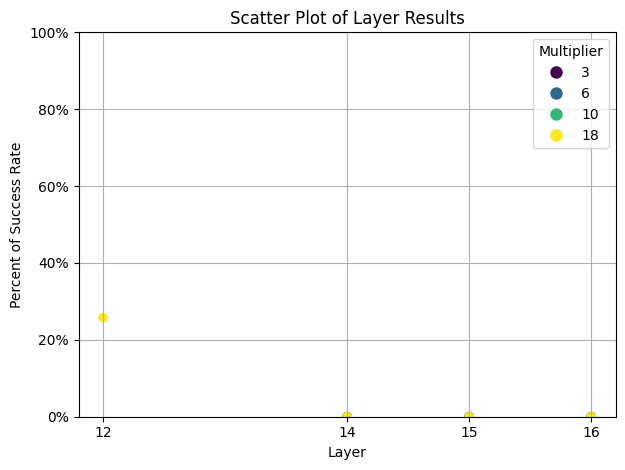

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(base).T * 100 # .T transposes the DataFrame so that outer keys become index and inner keys become columns

# Prepare data for plotting
x_values = []
y_values = []
colors = []

# Get unique inner keys for color mapping
unique_inner_keys = sorted(df.columns.astype(int).unique()) # Convert to int for proper sorting

# Create a color map for each unique inner key
cmap = plt.cm.get_cmap('viridis', len(unique_inner_keys))
color_map_dict = {key: cmap(i) for i, key in enumerate(unique_inner_keys)}

for outer_key in df.index:
    for inner_key in df.columns:
        x_values.append(int(outer_key)) # Convert outer key to int for numerical x-axis
        y_values.append(df.loc[outer_key, inner_key])
        colors.append(color_map_dict[int(inner_key)])

# Create the scatter plot
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
scatter = plt.scatter(x_values, y_values, c=colors)

# Create custom legend handles and labels
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map_dict[key], markersize=10) for key in unique_inner_keys]
labels = [str(key) for key in unique_inner_keys]

plt.legend(handles, labels, title='Multiplier')
plt.xlabel('Layer')
plt.ylabel('Percent of Success Rate')
plt.title('Scatter Plot of Layer Results')
plt.grid(True)
import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(sorted([int(k) for k in df.index.unique()])) # Ensure x-ticks are correctly placed for integer keys
plt.tight_layout()
plt.ylim((0,100))
plt.show()

In [8]:
import json
asdf = json.load(open("steering_graph_results_neg.json","r"))
bcde = json.load(open("steering_graph_results_neg_12_18.json","r"))

In [9]:
import re
import numpy as np

def get_layer_results(asdf):
    match_digit = lambda x: re.findall(r'\d+',x)
    expected = '1'
    layerwise = {}
    for key in asdf['neg']:
        for layer in asdf['neg'][key]:
            if layer not in layerwise:
                layerwise[layer] = {}
            for mult in asdf['neg'][key][layer]:
                if mult not in layerwise[layer]:
                    layerwise[layer][mult] = []
                if asdf['neg'][key][layer][mult] == {}:
                    continue
                res = asdf['neg'][key][layer][mult]['pos']
                expect = asdf['neg'][key][layer][mult]['none']
                res_num = match_digit(res)
                try:
                    ex_num = match_digit(expect)[0]
                except IndexError:
                    continue
                if len(res_num) == 0:
                    res_num = ['fail']
                layerwise[layer][mult].append((res_num[0] != ex_num and res_num[0] != 'fail'))
    layer_results = {}
    for layer in layerwise:
        layer_results[layer]=layer_results.get(layer, {})

        for mult in layerwise[layer]:
            layer_results[layer][mult]=layer_results[layer].get(mult, {})
            layer_results[layer][mult] = np.sum(layerwise[layer][mult]) / len(layerwise[layer][mult])
    return layer_results

In [10]:
base = get_layer_results(asdf)
base.update(get_layer_results(bcde))

In [12]:
base

{'14': {'3': np.float64(0.0),
  '6': np.float64(0.3870967741935484),
  '10': np.float64(0.9612903225806452),
  '18': np.float64(0.8838709677419355)},
 '15': {'3': np.float64(0.0064516129032258064),
  '6': np.float64(0.0064516129032258064),
  '10': np.float64(0.967741935483871),
  '18': np.float64(0.967741935483871)},
 '16': {'3': np.float64(0.0),
  '6': np.float64(0.0),
  '10': np.float64(0.025806451612903226),
  '18': np.float64(0.9741935483870968)},
 '12': {'18': np.float64(0.8516129032258064)}}

/tmp/ipykernel_407512/261637117.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_inner_keys))


<Figure size 1000x600 with 0 Axes>

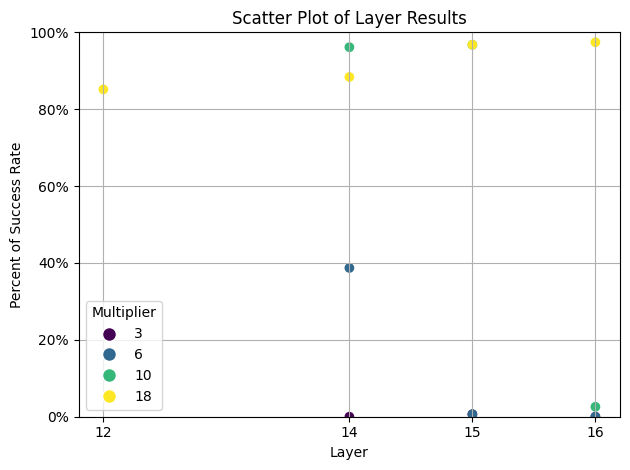

In [364]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(base).T * 100 # .T transposes the DataFrame so that outer keys become index and inner keys become columns

# Prepare data for plotting
x_values = []
y_values = []
colors = []

# Get unique inner keys for color mapping
unique_inner_keys = sorted(df.columns.astype(int).unique()) # Convert to int for proper sorting

# Create a color map for each unique inner key
cmap = plt.cm.get_cmap('viridis', len(unique_inner_keys))
color_map_dict = {key: cmap(i) for i, key in enumerate(unique_inner_keys)}

for outer_key in df.index:
    for inner_key in df.columns:
        x_values.append(int(outer_key)) # Convert outer key to int for numerical x-axis
        y_values.append(df.loc[outer_key, inner_key])
        colors.append(color_map_dict[int(inner_key)])

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.size()
scatter = plt.scatter(x_values, y_values, c=colors)

# Create custom legend handles and labels
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map_dict[key], markersize=10) for key in unique_inner_keys]
labels = [str(key) for key in unique_inner_keys]

plt.legend(handles, labels, title='Multiplier')
plt.xlabel('Layer')
plt.ylabel('Percent of Success Rate')
plt.title('Scatter Plot of Layer Results')
plt.grid(True)
import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(sorted([int(k) for k in df.index.unique()])) # Ensure x-ticks are correctly placed for integer keys
plt.tight_layout()
plt.ylim((0,100))
plt.show()

In [154]:
import json
asdf = json.load(open("steering_graph_results_normalized_pos.json","r"))

In [ ]:
import re
match_digit = lambda x: re.findall(r'\d+',x)
expected = '1'
layerwise = {}
for key in asdf['pos']:
    for layer in asdf['pos'][key]:
        if layer not in layerwise:
            layerwise[layer] = {}
        for mult in asdf['pos'][key][layer]:
            if mult not in layerwise[layer]:
                layerwise[layer][mult] = []
            if asdf['pos'][key][layer][mult] == {}:
                continue
            res = asdf['pos'][key][layer][mult]['pos']
            expect = asdf['pos'][key][layer][mult]['none']
            res_num = match_digit(res)
            try:
                ex_num = match_digit(expect)[0]
            except IndexError:
                continue
            if len(res_num) == 0:
                res_num = ['fail']
            layerwise[layer][mult].append((res_num[0] != ex_num and res_num[0] != 'fail'))

In [161]:
import numpy as np
layer_results = {}
for layer in layerwise:
    layer_results[layer]=layer_results.get(layer, {})

    for mult in layerwise[layer]:
        layer_results[layer][mult]=layer_results[layer].get(mult, {})
        layer_results[layer][mult] = np.sum(layerwise[layer][mult]) / len(layerwise[layer][mult])

In [162]:
layer_results

{'14': {'3': np.float64(0.0),
  '6': np.float64(0.0),
  '10': np.float64(0.0),
  '18': np.float64(0.0)},
 '15': {'3': np.float64(0.0),
  '6': np.float64(0.0),
  '10': np.float64(0.0),
  '18': np.float64(0.0)},
 '16': {'3': np.float64(0.0),
  '6': np.float64(0.0),
  '10': np.float64(0.0),
  '18': np.float64(0.0)}}

In [6]:
import pickle
# Example: a random direction with the same hidden size
STEERING_VECTOR_FILE_PATH = "steering_vector_unnormalized_meandiff_normalized_nuisance_normalized_steering.pkl"
PROMPTS_FILE_PATH_FULL = "vector_steering_samples_full_balanced.json"
with open(STEERING_VECTOR_FILE_PATH, "rb") as f:
    steering_vectors = pickle.load(f)

steer_vec = steering_vectors[16][0]                 # scale = “strength” of steering
steer_vec = steer_vec * 6

In [7]:
import json
import pprint
prompts = []
with open(PROMPTS_FILE_PATH_FULL, 'r') as f:
    prompts_raw = json.load(f)
# pprint.pprint(prompts_raw)


In [ ]:

import re
import datetime
import os
# 🔹 load the whole dict  {layer_idx: [vec0, vec1, …]}
with open("steering_vector_unnormalized_meandiff_normalized_nuisance_normalized_steering.pkl", "rb") as f:
    steering_vectors = pickle.load(f)

# ------------------------------------------------------------------
# 1.  EXPERIMENT SETTINGS
# ------------------------------------------------------------------
layers   = [5,8,10,12,15,18,20]           # choose any subset present in dict
mults    = [1, 3, 5, 8, 10]                # magnitude multipliers
max_new  = 3                           # tokens to generate
temperature = 0.7
top_p       = 0.95

results = {"results": []}

# ------------------------------------------------------------------
# 2.  HOOK HELPERS  (identical to robust version from last reply)
# ------------------------------------------------------------------
def make_steering_hook(vector: torch.Tensor, token_pos: int = -1, once=True):
    call_ctr = {"n": 0}
    def _hook(module, inputs, outputs):
        if once and call_ctr["n"] > 0:
            return outputs
        call_ctr["n"] += 1

        def add(h):
            h = h.clone()
            h[:, token_pos, :] += vector.to(h.device, dtype=h.dtype)
            return h

        if isinstance(outputs, torch.Tensor):
            return add(outputs)
        if isinstance(outputs, tuple):                       # (hidden, *others)
            hidden = add(outputs[0])
            return (hidden, *outputs[1:])
        return outputs
    return _hook

from contextlib import contextmanager
@contextmanager
def steering_layer(model, layer_idx, vector, token_pos=-1, once=True):
    handle = model.model.layers[layer_idx].register_forward_hook(
        make_steering_hook(vector, token_pos, once)
    )
    try:
        yield
    finally:
        handle.remove()

# ------------------------------------------------------------------
# 3.  GENERATION HELPERS (now pulls vector per‑layer) 🔹
# ------------------------------------------------------------------
def build_inputs(prompt_str):
    msgs = [
        {"role": "system", "content": "You are a concise assistant."},
        {"role": "user",   "content": prompt_str}
    ]
    prompt = tok.apply_chat_template(msgs, add_generation_prompt=True, tokenize=False)
    toked  = tok(prompt, return_tensors="pt").to(model.device)
    return toked, -1                       # inject at last token

def generate_with_vec(prompt_str, layer_idx, base_vec, scale):
    toked, pos = build_inputs(prompt_str)
    vec = (base_vec * scale).to(model.dtype)
    with steering_layer(model, layer_idx, vec, pos, once=True):
        out_ids = model.generate(
            **toked,
            max_new_tokens=max_new,
            temperature=temperature,
            top_p=top_p,
            do_sample=True
        )
    return tok.decode(out_ids[0], skip_special_tokens=True)

# ------------------------------------------------------------------
# 4.  MAIN LOOP  –  MULTI‑LAYER + MULTI‑STRENGTH + ±VECTOR
# ------------------------------------------------------------------
run_id = 0
stats = []
for key in ["pos","neg"]:
    for record in tqdm(prompts_raw[key], desc=f"dataset:{key}"):
        for pas in ["forward_prompt", "backward_prompt"]:
            prompt_text = record[pas]
            for layer in layers:
                if layer not in steering_vectors:
                    print(f"⚠️  no vector for layer {layer}; skipping")
                    continue
                base_vec = steering_vectors[layer][0]   # take first vector per layer

                for m in mults:
                    ones = 0
                    twoes = 0
                    sign = 1
                    comp = generate_with_vec(
                        prompt_text,
                        layer_idx=layer,
                        base_vec=base_vec,
                        scale=sign * m
                    )
                    comp = comp.split("text.assistant")[-1].strip() 
                    if comp == "1":
                        ones += 1
                    if comp == "2":
                        twoes += 1
                    result = {
                        "id"      : run_id,
                        "dataset" : key,
                        "prompt"  : prompt_text,
                        "layer"   : layer,
                        "sign"    : sign,
                        "mult"    : sign * m,
                        "output"  : comp,
                    }
                    
                    pprint.pprint({"id":run_id, "layer": layer, "mult": sign*m,"output":comp})
                    results["results"].append(result)
                    run_id += 1
                        

# ------------------------------------------------------------------
# 5.  SAVE RESULTS
# ------------------------------------------------------------------
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
fn = f"llama3_layered_steering_{ts}.jsonl"
with open(fn, "w", encoding="utf‑8") as f:
    for row in results["results"]:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

print(f"✅ Saved {len(results['results'])} generations → {os.path.abspath(fn)}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'id': 0, 'layer': 3, 'mult': 1, 'output': '1'}


dataset:pos:   0%|          | 0/1356 [00:15<?, ?it/s]


KeyboardInterrupt: 